In [11]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
import keras
%matplotlib inline



In [14]:

images = []
steerings = []

folder = 'data2'

with open(folder + '/driving_log.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        abs_filepath = line[0]
        base = os.path.basename(abs_filepath)
        img = cv2.imread(folder + '/IMG/' + base)
        images.append(img)
        steerings.append(float(line[3]))

train_X = np.array(images)
train_y = np.array(steerings)

print(train_X.shape)
print(train_y.shape)


(1318, 160, 320, 3)
(1318,)


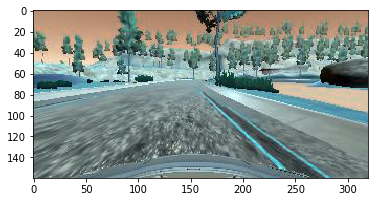

In [15]:
plt.imshow(img)

In [16]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(keras.layers.Convolution2D(6, 5, 5, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Convolution2D(6, 5, 5, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 160, 320, 3)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 156, 316, 6)   456         lambda_3[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 78, 158, 6)    0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 74, 154, 6)    906         maxpooling2d_5[0][0]             
___________________________________________________________________________________________

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

model.fit(train_X, train_y, validation_split=0.2, shuffle=True, callbacks=[early_stop])

Train on 1054 samples, validate on 264 samples
Epoch 1/10
1054/1054 [==============================] - 36s - loss: 17.1852 - val_loss: 0.0537
Epoch 2/10
1054/1054 [==============================] - 37s - loss: 0.0946 - val_loss: 0.0171
Epoch 3/10
1054/1054 [==============================] - 36s - loss: 0.0289 - val_loss: 0.0085
Epoch 4/10
1054/1054 [==============================] - 36s - loss: 0.0207 - val_loss: 0.0094
Epoch 5/10
1054/1054 [==============================] - 36s - loss: 0.0197 - val_loss: 0.0095


In [18]:
model.save('model3.h5')